# Cascade regridding

This notebook explores regridding in cascade, which is apparently a thing that downscalers do when the difference in resolution between native and target grids is large! And that gap is indeed large in our case, ~100 km --> 4km...

In [17]:
import xarray as xr
import numpy as np
from pyproj import CRS, Transformer, Proj
import xesmf as xe
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt
import warnings

First get the ERA5 data for the target grid. Need to add lat and lon coordinates to that data if not present (development of reprojected ERA5 dataset is in active development and this could change).

In [22]:
# get the ERA5 data now so we can have a refernce grid to crop the CMIP6 data before regridding
era5_ds = xr.open_dataset(
    "/center1/CMIP6/kmredilla/daily_era5_4km_3338/netcdf/pr/pr_2010_era5_4km_3338.nc"
)
time_sl = slice("2010-01-01", "2010-12-31")
target_slice = era5_ds["pr"].sel(time=time_sl, drop=True)

transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(target_slice["x"].values, target_slice["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
target_slice = target_slice.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

Get a source CMIP6 GCM data file, subset to the target domain, and create a new dataset that is twice the resolution:

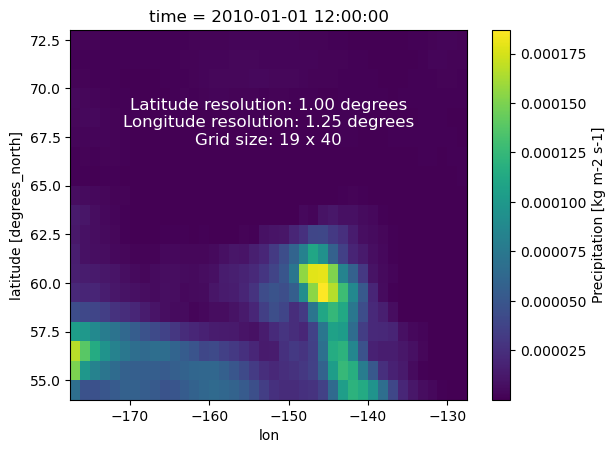

In [ ]:
var_id = "pr"
src_fp = f"/beegfs/CMIP6/arctic-cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/{var_id}/gr1/v20190726/{var_id}_day_GFDL-ESM4_historical_r1i1p1f1_gr1_20100101-20141231.nc"

ds = xr.open_dataset(src_fp)

subset_di = dict(
    lat=slice(target_slice.lat.min() - 1, target_slice.lat.max() + 1),
    lon=slice(target_slice.lon.min() - 1, target_slice.lon.max() + 1),
)

subset_ds = (
    ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    .sortby("lon")
    .sel(**subset_di)
    .sel(time=time_sl, drop=True)
)

subset_ds["pr"].isel(time=0).plot()
plt.text(
    0.5,
    0.75,
    f"Latitude resolution: {subset_ds.lat.diff(dim='lat').mean().values:.2f} degrees\n"
    f"Longitude resolution: {subset_ds.lon.diff(dim='lon').mean().values:.2f} degrees\n"
    f"Grid size: {len(subset_ds.lat)} x {len(subset_ds.lon)}",
    fontsize=12,
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
    color="white",
)
plt.show()

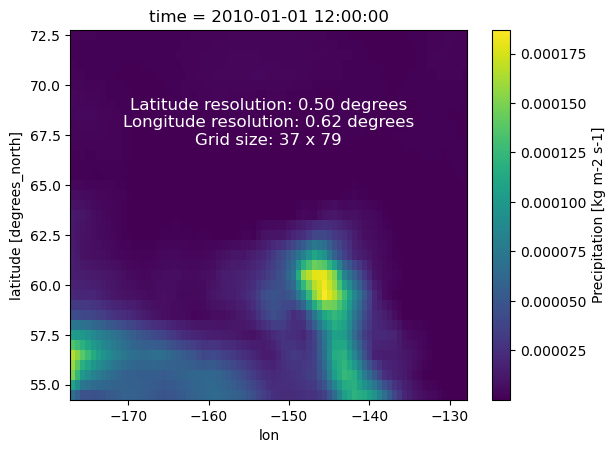

In [ ]:
# Double the resolution by interpolating latitude and longitude
new_lat = np.linspace(
    subset_ds.lat.values.min(), subset_ds.lat.values.max(), len(subset_ds.lat) * 2 - 1
)
new_lon = np.linspace(
    subset_ds.lon.values.min(), subset_ds.lon.values.max(), len(subset_ds.lon) * 2 - 1
)

# this is essentially a bilinear interpolation to the half grid
mid_res_ds = subset_ds.interp(lat=new_lat, lon=new_lon, method="linear")

mid_res_ds["pr"].isel(time=0).plot()
plt.text(
    0.5,
    0.75,
    f"Latitude resolution: {mid_res_ds.lat.diff(dim='lat').mean().values:.2f} degrees\n"
    f"Longitude resolution: {mid_res_ds.lon.diff(dim='lon').mean().values:.2f} degrees\n"
    f"Grid size: {len(mid_res_ds.lat)} x {len(mid_res_ds.lon)}",
    fontsize=12,
    ha="center",
    va="center",
    transform=plt.gca().transAxes,
    color="white",
)
plt.show()

In [27]:
# now regrid this to the target slice
regridder = xe.Regridder(mid_res_ds, target_slice, "bilinear", unmapped_to_nan=True)

with warnings.catch_warnings():
    # for ignoring input array is not C_CONTUIGUOUS
    warnings.simplefilter("ignore")
    # This will regrid the data to the target slice
    cascade_regrid = regridder(mid_res_ds, keep_attrs=True)

In [ ]:
single_regridder = xe.Regridder(
    subset_ds, target_slice, "bilinear", unmapped_to_nan=True
)


with warnings.catch_warnings():
    # for ignoring input array is not C_CONTUIGUOUS
    warnings.simplefilter("ignore")
    # This will regrid the data to the target slice
    single_regrid = single_regridder(subset_ds, keep_attrs=True)

Here is a plot of the different regridding results for a single day time slice, with original data included:

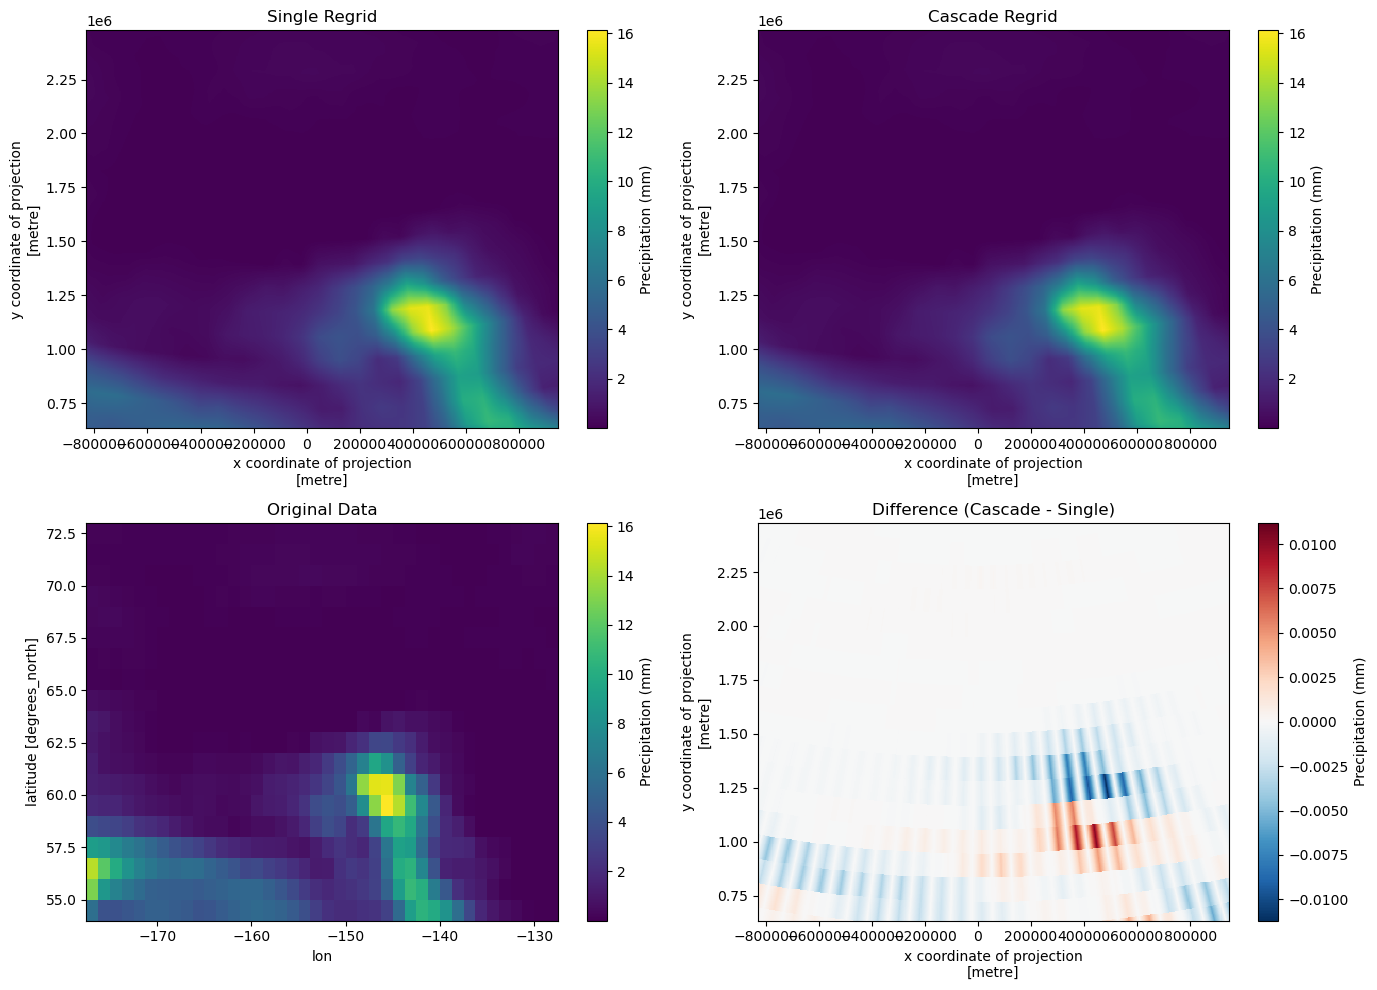

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot single_regrid
time_str = "2010-01-01"
convert_units_to(single_regrid["pr"], "mm/day").sel(time=time_str).plot(
    ax=axes[0][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][0].set_title("Single Regrid")

# Plot cascade_regrid
convert_units_to(cascade_regrid["pr"], "mm/day").sel(time=time_str).plot(
    ax=axes[0][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][1].set_title("Cascade Regrid")

convert_units_to(subset_ds["pr"], "mm/day").sel(time=time_str).plot(
    ax=axes[1][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][0].set_title("Original Data")

delta = cascade_regrid["pr"].sel(time=time_str) - single_regrid["pr"].sel(time=time_str)
delta.attrs["units"] = cascade_regrid["pr"].attrs["units"]
delta.attrs["standard_name"] = cascade_regrid
convert_units_to(delta, "mm/day").plot(
    ax=axes[1][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][1].set_title("Difference (Cascade - Single)")

plt.tight_layout()
plt.show()

Here is the same graphic but for maximum precipitation values:

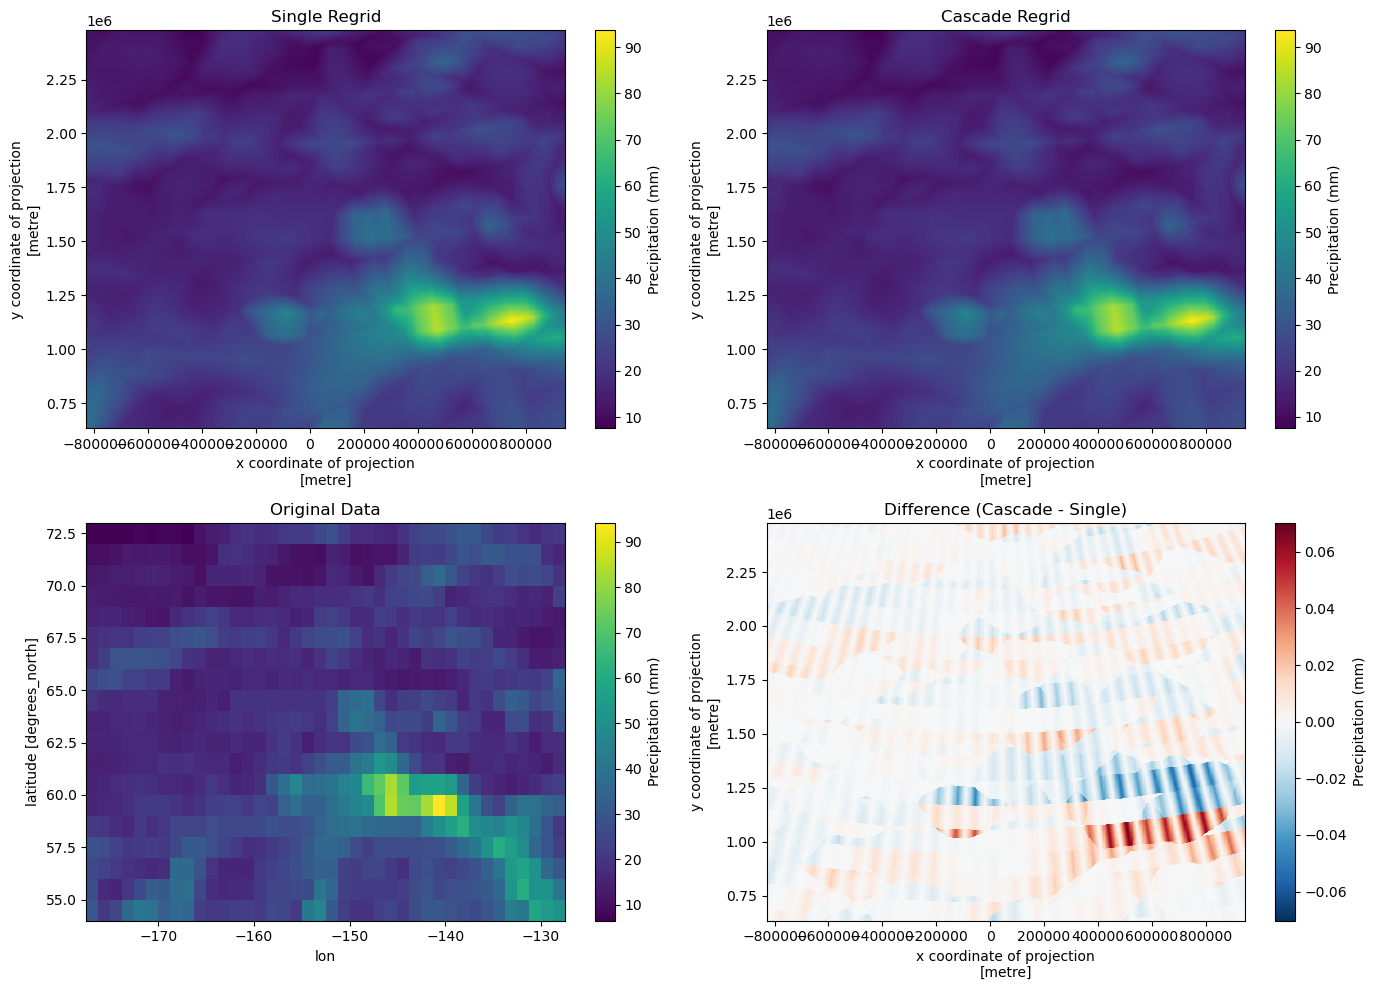

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot single_regrid
time_str = "2010-01-01"
convert_units_to(single_regrid["pr"], "mm/day").max("time").plot(
    ax=axes[0][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][0].set_title("Single Regrid")

# Plot cascade_regrid
convert_units_to(cascade_regrid["pr"], "mm/day").max("time").plot(
    ax=axes[0][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][1].set_title("Cascade Regrid")

convert_units_to(subset_ds["pr"], "mm/day").max("time").plot(
    ax=axes[1][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][0].set_title("Original Data")

delta = cascade_regrid["pr"].max("time") - single_regrid["pr"].max("time")
delta.attrs["units"] = cascade_regrid["pr"].attrs["units"]
delta.attrs["standard_name"] = cascade_regrid
convert_units_to(delta, "mm/day").plot(
    ax=axes[1][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][1].set_title("Difference (Cascade - Single)")

plt.tight_layout()
plt.show()

And for mean precip:

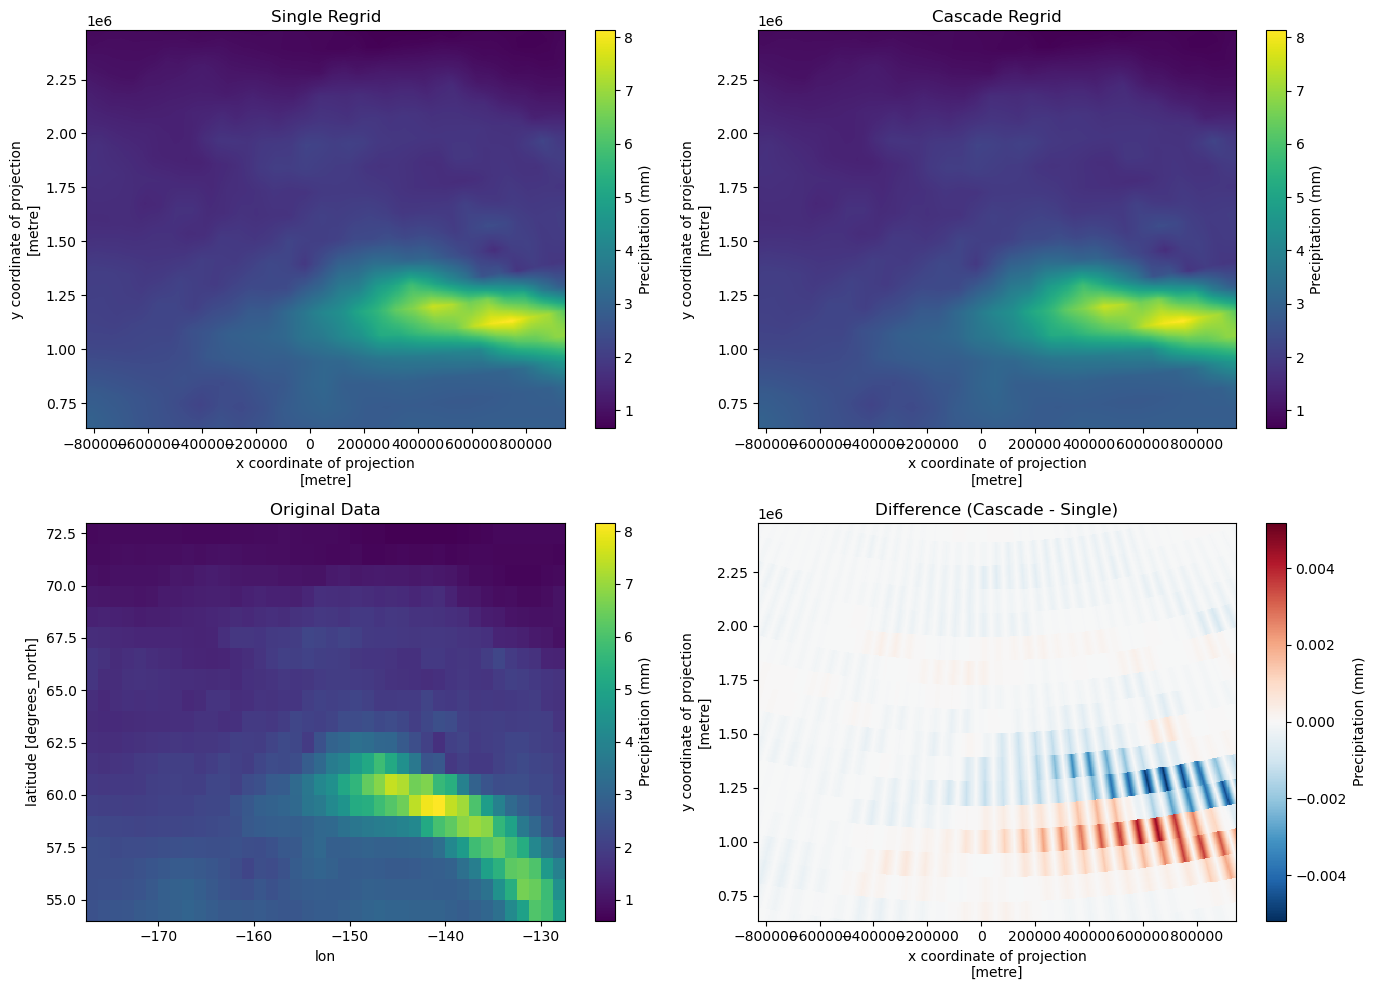

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot single_regrid
time_str = "2010-01-01"
convert_units_to(single_regrid["pr"], "mm/day").mean("time").plot(
    ax=axes[0][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][0].set_title("Single Regrid")

# Plot cascade_regrid
convert_units_to(cascade_regrid["pr"], "mm/day").mean("time").plot(
    ax=axes[0][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[0][1].set_title("Cascade Regrid")

convert_units_to(subset_ds["pr"], "mm/day").mean("time").plot(
    ax=axes[1][0], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][0].set_title("Original Data")

delta = cascade_regrid["pr"].mean("time") - single_regrid["pr"].mean("time")
delta.attrs["units"] = cascade_regrid["pr"].attrs["units"]
delta.attrs["standard_name"] = cascade_regrid
convert_units_to(delta, "mm/day").plot(
    ax=axes[1][1], cbar_kwargs={"label": "Precipitation (mm)"}
)
axes[1][1].set_title("Difference (Cascade - Single)")

plt.tight_layout()
plt.show()